In [1]:
import sys; sys.path.append('..')
from osp import *
import html


In [2]:
# for id,docstr in STASH_SLICES_NLP.items():
#     break
# doc=stanza.Document.from_serialized(docstr)
# sent = random.choice(doc.sentences)
txt = """
These words, it seems to me, give us a particular picture of the
essence of human language. It is this: the individual words in language
name objects—sentences are combinations of such names.——In this
picture of language we find the roots of the following idea: Every word
has a meaning. This meaning is correlated with the word. It is the
object for which the word stands.
"""
# txt = """It is not – as it was previously thought – that, that however hard he fought he lost, but rather that he fought in order to lose."""

doc = get_nlp_doc(txt)
sent = doc.sentences[0]

In [21]:

def extract_pos_feats_sent(sent):
    counter = Counter()
    for word in sent.words:
        pos = word.xpos
        if pos not in BAD_POS and pos and pos[0].isalpha():
            counter[pos] += 1
    return counter

def extract_pos_feats(doc):
    counter = Counter()
    for sent in doc.sentences:
        sent_pos_feats = extract_pos_feats_sent(sent)
        for pos,count in sent_pos_feats.items():
            counter[pos] += count
    return counter

extract_pos_feats(doc)

Counter({'DT': 14,
         'NN': 14,
         'IN': 10,
         'NNS': 7,
         'PRP': 6,
         'VBZ': 6,
         'JJ': 4,
         'VBP': 2,
         'VB': 1,
         'VBG': 1,
         'VBN': 1,
         'WDT': 1})

In [22]:
def extract_deprel_feats_sent(sent):
    counter = Counter()
    for word in sent.words:
        deprel = word.deprel
        if deprel not in BAD_DEPREL:
            counter[deprel] += 1
    return counter

def extract_deprel_feats(doc):
    counter = Counter()
    for sent in doc.sentences:
        sent_deprel_feats = extract_deprel_feats_sent(sent)
        for deprel,count in sent_deprel_feats.items():
            counter[deprel] += count
    return counter

extract_deprel_feats(doc)

Counter({'det': 13,
         'punct': 12,
         'case': 10,
         'nsubj': 9,
         'nmod': 6,
         'root': 5,
         'amod': 5,
         'obl': 4,
         'parataxis': 3,
         'obj': 3,
         'cop': 3,
         'compound': 2,
         'iobj': 1,
         'nsubj:pass': 1,
         'aux:pass': 1,
         'acl:relcl': 1})

In [23]:
def extract_phrase_feats_sent(sent):
    counter = Counter()
    tree = get_sent_tree(sent)
    for node in tree.subtrees():
        label = node.label()
        if label.isalpha() and label not in POS2DESC:
            counter[label] += 1
    return counter

def extract_phrase_feats(doc):
    counter = Counter()
    for sent in doc.sentences:
        sent_phrase_feats = extract_phrase_feats_sent(sent)
        for phrase,count in sent_phrase_feats.items():
            counter[phrase] += count
    return counter
    
extract_phrase_feats(doc)

Counter({'NP': 35,
         'S': 10,
         'VP': 10,
         'PP': 9,
         'ROOT': 5,
         'PRN': 1,
         'SBAR': 1,
         'WHPP': 1,
         'WHNP': 1})

In [32]:
def extract_slice_feats(docstr, normalize=True):
    # from .constants import CONTEXT_LEN, BAD_POS, BAD_DEPREL
    # from .nlp_utils import get_sent_stats, get_word_context
    
    doc = stanza.Document.from_serialized(docstr) if isinstance(docstr, str) else docstr
    if doc is None:
        return {}

    feats_d = {}
    feats_d['pos'] = extract_pos_feats(doc)
    feats_d['deprel'] = extract_deprel_feats(doc)
    feats_d['phrase'] = extract_phrase_feats(doc)

    out_d = {
        **{'pos_'+k: v for k,v in feats_d['pos'].items()},
        **{'deprel_'+k: v for k,v in feats_d['deprel'].items()},
        **{'phrase_'+k: v for k,v in feats_d['phrase'].items()},
    }

    if normalize:
        num_words = sum(len(sent.words) for sent in doc.sentences)
        for k,v in out_d.items():
            out_d[k] = v / num_words * 1000
    return out_d

In [ ]:
# extract_slice_feats(doc)

{'pos_DT': 177.21518987341773,
 'pos_NNS': 88.60759493670886,
 'pos_PRP': 75.9493670886076,
 'pos_VBZ': 75.9493670886076,
 'pos_IN': 126.58227848101266,
 'pos_VB': 12.658227848101266,
 'pos_JJ': 50.63291139240506,
 'pos_NN': 177.21518987341773,
 'pos_VBP': 25.31645569620253,
 'pos_VBG': 12.658227848101266,
 'pos_VBN': 12.658227848101266,
 'pos_WDT': 12.658227848101266,
 'deprel_det': 164.55696202531644,
 'deprel_nsubj': 113.92405063291139,
 'deprel_punct': 151.8987341772152,
 'deprel_parataxis': 37.9746835443038,
 'deprel_case': 126.58227848101266,
 'deprel_obl': 50.63291139240506,
 'deprel_root': 63.29113924050633,
 'deprel_iobj': 12.658227848101266,
 'deprel_amod': 63.29113924050633,
 'deprel_obj': 37.9746835443038,
 'deprel_nmod': 75.9493670886076,
 'deprel_cop': 37.9746835443038,
 'deprel_compound': 25.31645569620253,
 'deprel_nsubj:pass': 12.658227848101266,
 'deprel_aux:pass': 12.658227848101266,
 'deprel_acl:relcl': 12.658227848101266,
 'phrase_ROOT': 63.29113924050633,
 'phrase

In [77]:
def get_syntax_df(
    sent,
    index_cols=['clause_i','clause_id','clause_type','clause_head_id','clause_deprel','word_i']
    ):
    dfx=get_clauses_v2(sent).sort_values('word_i').rename(columns={'word_head':'word_head_i'})
    # dfx_wi = dfx.set_index('word_i')
    # for c in ['word','word_pos','word_deprel']:
        # dfx[f'head_{c}'] = [dfx_wi.loc[head_id, c] for head_id in dfx['word_head_i']]
    # dfx = dfx_wi.reset_index()
    # dfx['head_word'] = [dfx_wi.loc[head_id, 'word'] for head_id in dfx['word_head_i']]
    dfx['word_head_dist'] = (dfx['word_head_i'] - dfx['word_i']).abs()
    return dfx

In [78]:
POS2DESC

{'CC': 'Coordinating conjunction',
 'CD': 'Cardinal number',
 'DT': 'Determiner',
 'EX': 'Existential there',
 'FW': 'Foreign word',
 'IN': 'Preposition or subordinating conjunction',
 'JJ': 'Adjective',
 'JJR': 'Adjective, comparative',
 'JJS': 'Adjective, superlative',
 'LS': 'List item marker',
 'MD': 'Modal',
 'NN': 'Noun, singular or mass',
 'NNS': 'Noun, plural',
 'NNP': 'Proper noun, singular',
 'NNPS': 'Proper noun, plural',
 'PDT': 'Predeterminer',
 'POS': 'Possessive ending',
 'PRP': 'Personal pronoun',
 'PRP$': 'Possessive pronoun',
 'RB': 'Adverb',
 'RBR': 'Adverb, comparative',
 'RBS': 'Adverb, superlative',
 'RP': 'Particle',
 'SYM': 'Symbol',
 'TO': 'to',
 'UH': 'Interjection',
 'VB': 'Verb, base form',
 'VBD': 'Verb, past tense',
 'VBG': 'Verb, gerund or present participle',
 'VBN': 'Verb, past participle',
 'VBP': 'Verb, non-3rd person singular present',
 'VBZ': 'Verb, 3rd person singular present',
 'WDT': 'Wh-determiner',
 'WP': 'Wh-pronoun',
 'WP$': 'Possessive wh-pr

In [87]:
get_phrase_feats(sent, normalize_by=10)

Counter({'NP': 4.5, 'PP': 1.5, 'S': 1.0, 'VP': 1.0, 'ROOT': 0.5, 'PRN': 0.5})

In [67]:
dfx=get_syntax_df(sent)
dfx.sort_values('word_head_dist',ascending=False).mean(numeric_only=True)
# .reset_index()
# dfx.set_index(indby).sort_values('syntactic_distance',ascending=False)

clause_i          1.45
clause_id         1.75
clause_head_id    8.00
word_i            9.50
word_head_i       9.80
word_head_dist    3.10
dtype: float64

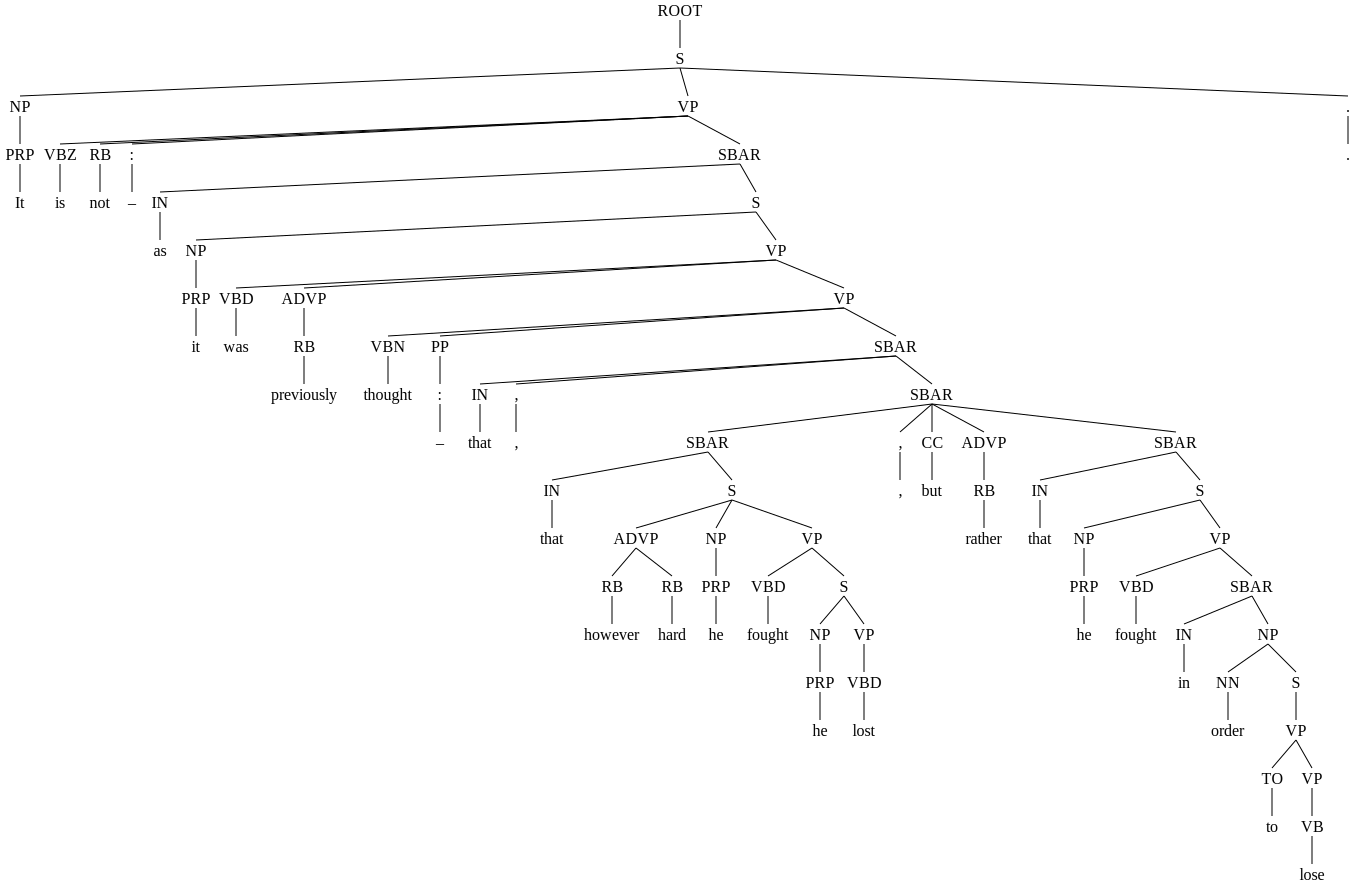

In [5]:
get_sent_tree(sent)